# Logist Regression - One-vs-all multi-class classification (Classes Approach)
    
## Introduction

This notebook is a simple approach to the Sign Language Digits Dataset using Logistic Regression. The dataset consists of 2062 64x64 images of hand signs representing numbers from 0 to 9. The goal is to classify the images into the correct number using logistic regression. We will use the accuracy score as the metric to evaluate the model pair with the confusion matrix, F1 score, precision and recall. We will also test with PCA to see if it improves the model.



## Libraries

We will use the following libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

## Data Loading

Load the data, which consists of features (X) and labels (Y), from `.npy` files.

In [3]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

print(X_original.shape)
print(Y_original.shape)

(2062, 64, 64)
(2062, 10)


## Data Organization

Since the dataset is not properly organized, we will organize it by the digit they represent, i.e, we will start with the digit 0 and end with the digit 9.

In [4]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])


# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)


Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Data Splitting (Training, Validation and Testing)

We will split the data into training and testing sets using the `train_test_split` function from the `sklearn` library.

In [5]:
# # We are going to create a training,test and validation array, 70% - training, 15% - test, 15% - cross validation

#reshape Y
correted_Y = np.argmax(correted_Y, axis=1)
correted_Y = correted_Y.reshape(-1, 1)

# reshape dataset to 2D, removing the third dimension
X_flatten = correted_X.reshape(correted_X.shape[0], correted_X.shape[1] * correted_X.shape[2])

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, correted_Y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

X_train shape: (1443, 4096)
Y_train shape: (1443, 1)
X_test shape: (309, 4096)
Y_test shape: (309, 1)
X_val shape: (310, 4096)
Y_val shape: (310, 1)


## Logistic Regression Approach (Classes Code)

### Sigmoid

In [51]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    # z = np.clip(z, -20, 20)

    gz = 1/(1 + np.exp(-z))
    
    return gz

### Cost Function Regularized

In [52]:
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    # number of training examples 
    m = X.shape[0]
        
    # vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    # epsilon = 1e-5
    error = (-y * np.log(h)) - ((1 - y) * np.log(1 - h))    
    # cost function without regularization term
    cost = sum(error)/m
    
    # add regularization term to the cost function
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # gradient of theta_0
    grad_0 = (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    # vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all = np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

### Gradient Descent

In [53]:
def gradientDescentWithCostTracking(X, y, X_val, y_val, X_test, y_test, theta, alpha, num_iters, Lambda):
    """
    Take in numpy arrays X, y, X_val, y_val, X_test, y_test, and theta, and update theta by taking num_iters
    gradient steps with learning rate alpha. Lambda is the regularization term.
    Return theta and the lists of the cost of theta during each iteration for the training, validation, and test sets.
    """
    
    J_history_train = []
    J_history_val = []
    J_history_test = []
    
    for i in range(num_iters):
        
        # Calculate the cost and gradient for the training set
        cost_train, grad = costFunctionReg(X, y, theta, Lambda)
        
        # Update theta
        theta = theta - (alpha * grad)
        
        # Calculate the cost for the validation set (no gradient needed)
        cost_val, _ = costFunctionReg(X_val, y_val, theta, Lambda)
        
        # Calculate the cost for the test set (no gradient needed)
        cost_test, _ = costFunctionReg(X_test, y_test, theta, Lambda)
        
        # Save the cost for this iteration
        J_history_train.append(cost_train)
        J_history_val.append(cost_val)
        J_history_test.append(cost_test)
    
    return theta, J_history_train, J_history_val, J_history_test


### One vs All Classification

In [54]:
def trainOneVsAll(X_train, y_train, X_val, y_val, X_test, y_test, initial_theta, alpha, num_iters, Lambda, K):
    all_theta = []
    train_J_history = []
    val_J_history = []
    test_J_history = []

    m, n = X_train.shape
    X_train = np.append(np.ones((m, 1)), X_train, axis=1)
    m_val, _ = X_val.shape
    X_val = np.append(np.ones((m_val, 1)), X_val, axis=1)
    m_test, _ = X_test.shape
    X_test = np.append(np.ones((m_test, 1)), X_test, axis=1)

    for i in range(1, K+1):
        y_train_i = np.where(y_train == i, 1, 0)
        y_val_i = np.where(y_val == i, 1, 0)
        y_test_i = np.where(y_test == i, 1, 0)
        theta, J_history_train, J_history_val, J_history_test = gradientDescentWithCostTracking(X_train, y_train_i, X_val, y_val_i, X_test, y_test_i, initial_theta, alpha, num_iters, Lambda)
        all_theta.append(theta.flatten())
        train_J_history.append(J_history_train)
        val_J_history.append(J_history_val)
        test_J_history.append(J_history_test)

    return np.array(all_theta), train_J_history, val_J_history, test_J_history


### One-vs-all Prediction


In [55]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m= X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    predictions = np.dot(X, all_theta.T) # predictions.shape =(5000,10)  X(5000x401) * all_theta(401x10) = 5000x10
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

### Plot Confusion Matrix

In [16]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Model Training and Evaluation

In [57]:
def train_and_analyze(oneVsAll, predictOneVsAll, X_train, y_train, X_test, y_test, X_val, y_val, learning_rate, num_iters, Lambda, K):
    # Número de features
    features = X_train.shape[1]
    theta = np.zeros((features + 1, 1))  # +1 para o termo de interceptação
    
    # Treinar o modelo usando a abordagem One-vs-All
    all_theta, train_J_history, val_J_history, test_J_history = trainOneVsAll(X_train, y_train, X_val, y_val, X_test, y_test, theta, learning_rate, num_iters, Lambda, K)
    
    # Plota a evolução da função de custo para treinamento, validação e teste
    plt.plot(np.mean(train_J_history, axis=0), label='Train Cost')
    plt.plot(np.mean(val_J_history, axis=0), label='Validation Cost')
    plt.plot(np.mean(test_J_history, axis=0), label='Test Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost function over iterations for training, validation, and test')
    plt.legend()
    plt.show()
    
    
    # Usar o theta treinado para fazer previsões nos conjuntos de teste e validação
    pred_test = predictOneVsAll(all_theta, X_test)
    pred_val = predictOneVsAll(all_theta, X_val)
    
    # Calcula e imprime métricas de desempenho para o conjunto de teste
    test_accuracy = accuracy_score(pred_test, y_test)
    test_f1 = f1_score(y_test, pred_test, average='weighted')
    
    # Calcula e imprime métricas de desempenho para o conjunto de validação
    val_accuracy = accuracy_score(pred_val, y_val)
    val_f1 = f1_score(y_val, pred_val, average='weighted')
    
    
    print()
    print ("---- Model Analysis ----")
    print(f"> Number of Iterations: {num_iters}")
    print(f"> Regularization Term (Lambda): {Lambda}")
    print(f"> Learning Rate: {learning_rate}")
    print()
    print("---- Test Set Analysis ----")
    print('Test Accuracy: ', test_accuracy)
    print('Test F1 Score: ', test_f1)
    print()
    print("\n---- Validation Set Analysis ----")
    print('Validation Accuracy: ', val_accuracy)
    print('Validation F1 Score: ', val_f1)
    print()
    
    # # Plota a matriz de confusão para o conjunto de treino
    cm_train = confusion_matrix(y_train, predictOneVsAll(all_theta, X_train))
    plot_confusion_matrix(cm_train, target_names=[str(i) for i in range(K)], normalize=False)
    plt.show()
    
    # # Plota a matriz de confusão para o conjunto de teste
    cm_test = confusion_matrix(y_test, pred_test)
    plot_confusion_matrix(cm_test, target_names=[str(i) for i in range(K)], normalize=False)
    plt.show()
    
    # # Plota a matriz de confusão para o conjunto de validação
    cm_val = confusion_matrix(y_val, pred_val)
    plot_confusion_matrix(cm_val, target_names=[str(i) for i in range(K)], normalize=False)
    plt.show()
    
    # Imprime relatório de classificação para o conjunto de treino
    print("---- Train Set Classification Report ----")
    print(classification_report(y_train, predictOneVsAll(all_theta, X_train)))
    
    # Imprime relatório de classificação para o conjunto de teste
    print("---- Test Set Classification Report ----")
    print(classification_report(y_test, pred_test))
    
    # Imprime relatório de classificação para o conjunto de validação
    print("---- Validation Set Classification Report ----")
    print(classification_report(y_val, pred_val))
    
    return all_theta

Number of features:  4096
Number of classes:  1
(1443, 4096)
(1443, 1)
(4097, 1)


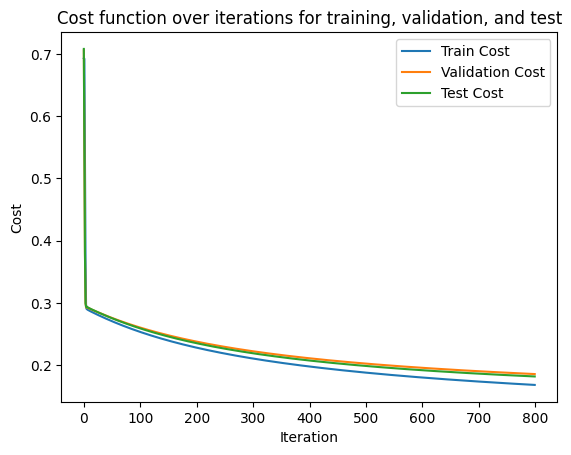


---- Model Analysis ----
> Number of Iterations: 800
> Regularization Term (Lambda): 0.1
> Learning Rate: 0.01

---- Test Set Analysis ----
Test Accuracy:  0.6310679611650486
Test F1 Score:  0.6005900832369092


---- Validation Set Analysis ----
Validation Accuracy:  0.6225806451612903
Validation F1 Score:  0.5921699290201985



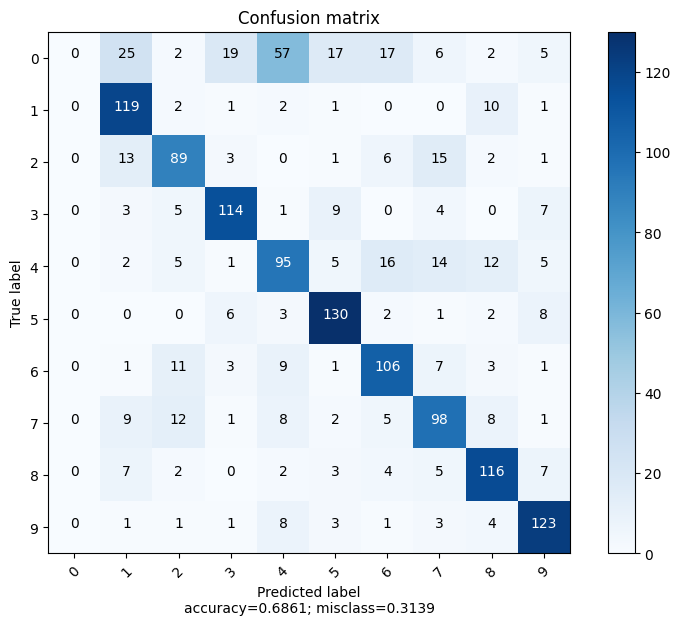

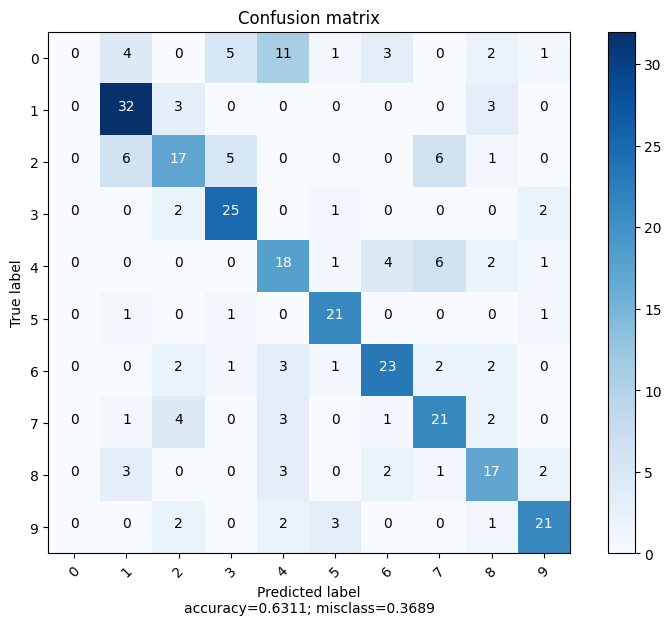

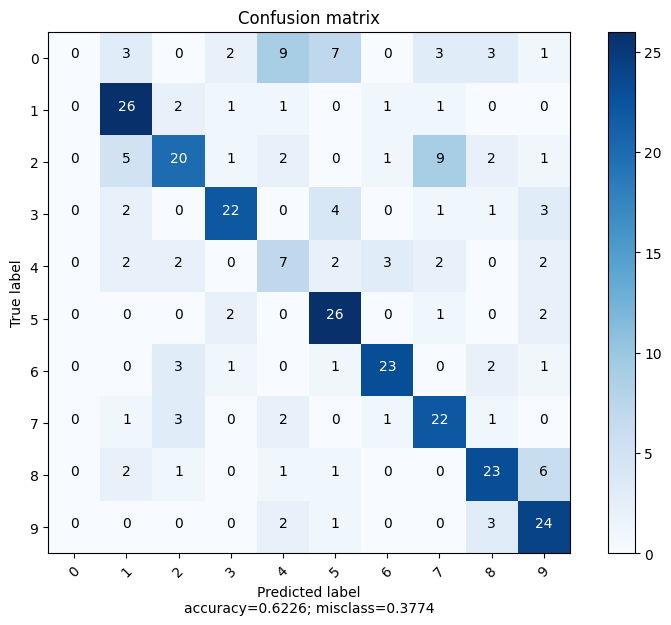

---- Train Set Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.66      0.88      0.75       136
           2       0.69      0.68      0.69       130
           3       0.77      0.80      0.78       143
           4       0.51      0.61      0.56       155
           5       0.76      0.86      0.80       152
           6       0.68      0.75      0.71       142
           7       0.64      0.68      0.66       144
           8       0.73      0.79      0.76       146
           9       0.77      0.85      0.81       145

    accuracy                           0.69      1443
   macro avg       0.62      0.69      0.65      1443
weighted avg       0.62      0.69      0.65      1443

---- Test Set Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.68      0.84      0.75      

/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [58]:
#Number of features
features = X_train.shape[1]

print('Number of features: ', features)
print('Number of classes: ', Y_train.shape[1])

# Test with different learning rates
learning_rates = [0.01, 0.001] # 0.1, 0.3 are bad

theta = np.zeros((features+1, 1))  # +1 para o termo de interceptação

# Number of iterations
num_iters = 800

print(X_train.shape)
print(Y_train.shape)
print(theta.shape)

#Lambda
Lambda = 0.1
K = 10

# Train and analyze the model
all_theta = train_and_analyze(trainOneVsAll, predictOneVsAll, X_train, Y_train, X_test, Y_test, X_val, Y_val, learning_rates[0], num_iters, Lambda, K)


### Samples to Test

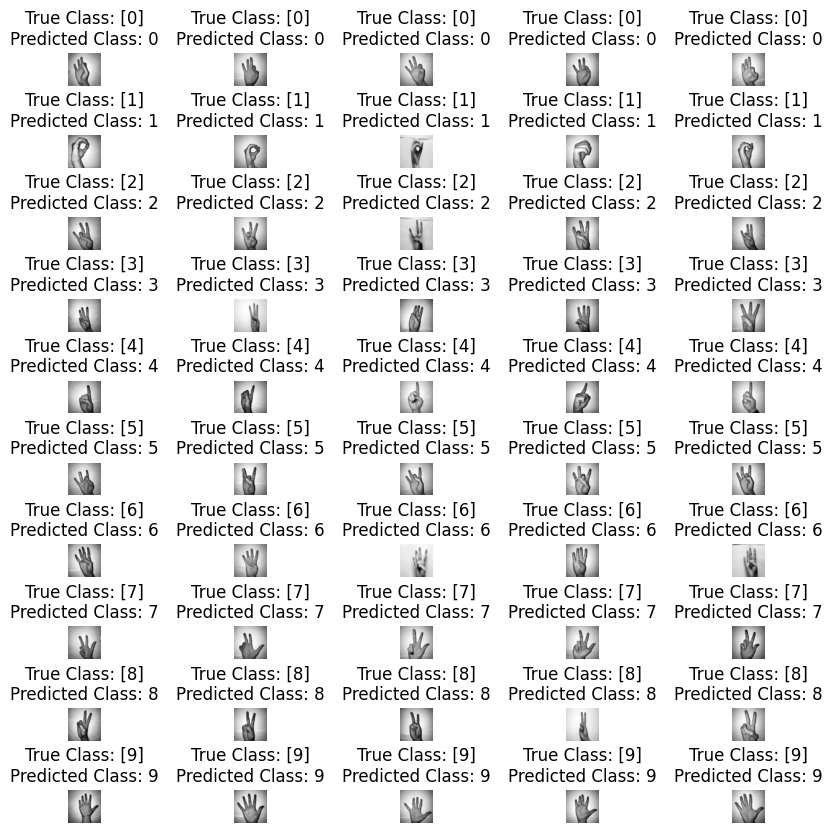

In [ ]:
# choose a random image to test the model

# Choose 5 images for every class to test the model

random_images = []

for i in range(10):
    random_images.append(np.where(Y_original == i)[0][0:5])
    
random_images = np.array(random_images).flatten()

# Plot the images

fig, axes = plt.subplots(10, 5, figsize=(10, 10))
for i in range(10):
    for j in range(5):
        axes[i, j].imshow(X_original[random_images[i*5 + j]], cmap='gray')
        axes[i, j].axis('off')
        # Get the true class
        true_class = Y_original[random_images[i*5 + j]]
        axes[i, j].set_title(f'True Class: {true_class}\nPredicted Class: {i}')

# Increase the space between the images and the titles
plt.subplots_adjust(hspace=1.5, wspace=0.5)

plt.show()

# Logist Regression - One-vs-all multi-class classification (Keras Approach)

## Model Training and Evaluation

In [22]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from tensorflow.keras import regularizers


def train_and_analyze_keras_not_tuned(X_train, y_train, X_test, y_test, X_val, y_val, num_classes):
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.fit_transform(y_test)
    y_val_encoded = encoder.fit_transform(y_val)
    
    y_train_encoded = np.eye(num_classes)[y_train_encoded]
    y_test_encoded = np.eye(num_classes)[y_test_encoded]
    y_val_encoded = np.eye(num_classes)[y_val_encoded]
    
    model = Sequential()
    model.add(Dense(units=num_classes, input_shape=(X_train.shape[1],), activation='softmax'))
    
    # optimizer
    sgd = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Compilar o modelo
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinar o modelo
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=800, batch_size=10, verbose=0)
    
    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Set Loss: {loss}, Test Set Accuracy: {accuracy}")
    
    # Plotar a evolução da função de custo e da acurácia
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Fazer previsões para análise adicional
    pred_train = np.argmax(model.predict(X_train), axis=-1)
    pred_test = np.argmax(model.predict(X_test), axis=-1)
    pred_val = np.argmax(model.predict(X_val), axis=-1)
    
    # Transformar previsões de volta para rótulos originais
    pred_train = encoder.inverse_transform(pred_train)
    pred_test = encoder.inverse_transform(pred_test)
    pred_val = encoder.inverse_transform(pred_val)
    
    # Metrics and Confusion Matrices
    for (preds, true, name) in [(pred_train, y_train, "Train"), (pred_test, y_test, "Test"), (pred_val, y_val, "Validation")]:
        print(f"\n---- {name} Set Analysis ----")
        accuracy = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')
        print(f"Accuracy: {accuracy}, F1 Score: {f1}")
        print("\nClassification Report:")
        print(classification_report(true, preds))
        
        # Confusion Matrix
        cm = confusion_matrix(true, preds)
        plot_confusion_matrix(cm, target_names=np.unique(y_train).astype(str), title=f'{name} Set Confusion Matrix', normalize=False)
            
    # Certifique-se de retornar ambos, model e encoder
    return model, encoder


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_

Test Set Loss: 27.328083038330078, Test Set Accuracy: 0.737864077091217


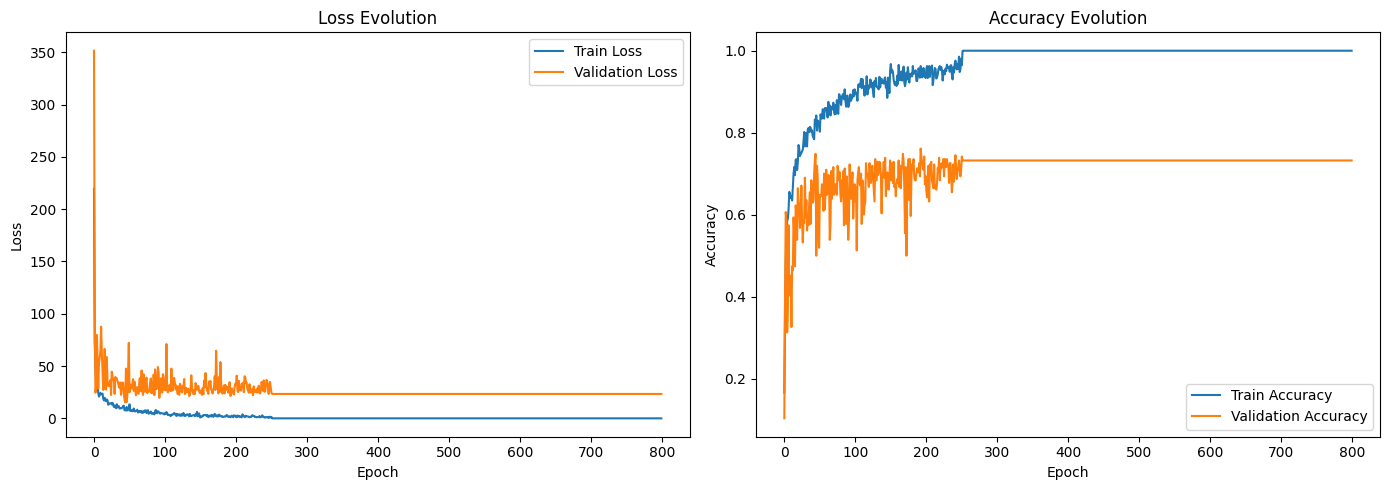

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step

---- Train Set Analysis ----
Accuracy: 1.0, F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00       155
           5       1.00      1.00      1.00       152
           6       1.00      1.00      1.00       142
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       146
           9       1.00      1.00      1.00       145

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443



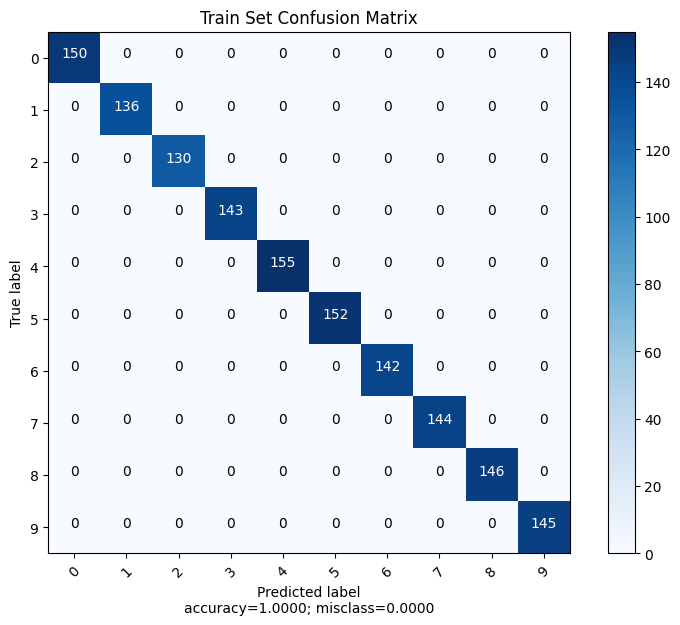


---- Test Set Analysis ----
Accuracy: 0.7378640776699029, F1 Score: 0.7363491232626245

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.92      0.87      0.89        38
           2       0.67      0.57      0.62        35
           3       0.76      0.93      0.84        30
           4       0.67      0.69      0.68        32
           5       0.86      0.79      0.83        24
           6       0.63      0.65      0.64        34
           7       0.63      0.59      0.61        32
           8       0.70      0.75      0.72        28
           9       0.84      0.72      0.78        29

    accuracy                           0.74       309
   macro avg       0.74      0.74      0.74       309
weighted avg       0.74      0.74      0.74       309



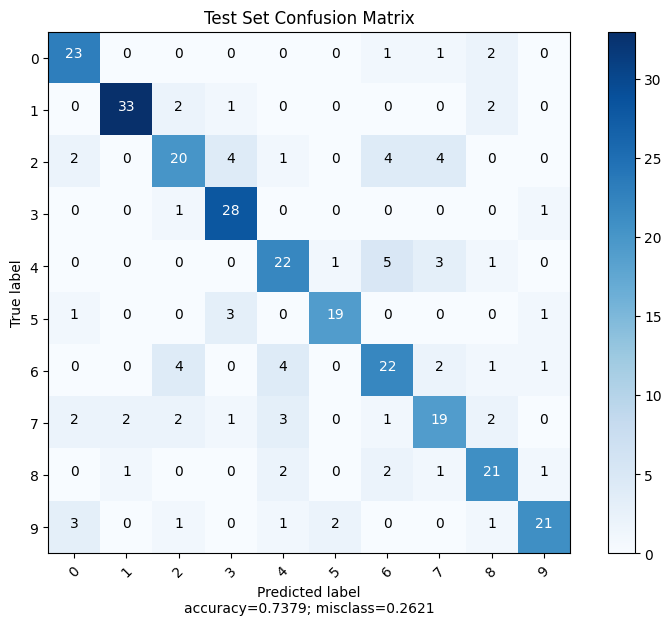


---- Validation Set Analysis ----
Accuracy: 0.7322580645161291, F1 Score: 0.729991516821806

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        28
           1       0.74      0.78      0.76        32
           2       0.81      0.51      0.63        41
           3       0.74      0.88      0.81        33
           4       0.53      0.50      0.51        20
           5       0.96      0.77      0.86        31
           6       0.72      0.68      0.70        31
           7       0.73      0.80      0.76        30
           8       0.68      0.68      0.68        34
           9       0.59      0.80      0.68        30

    accuracy                           0.73       310
   macro avg       0.74      0.73      0.73       310
weighted avg       0.74      0.73      0.73       310



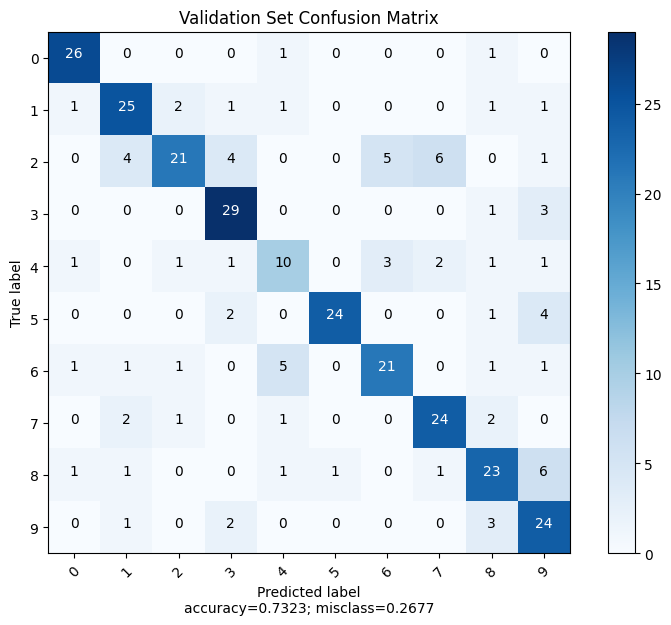

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

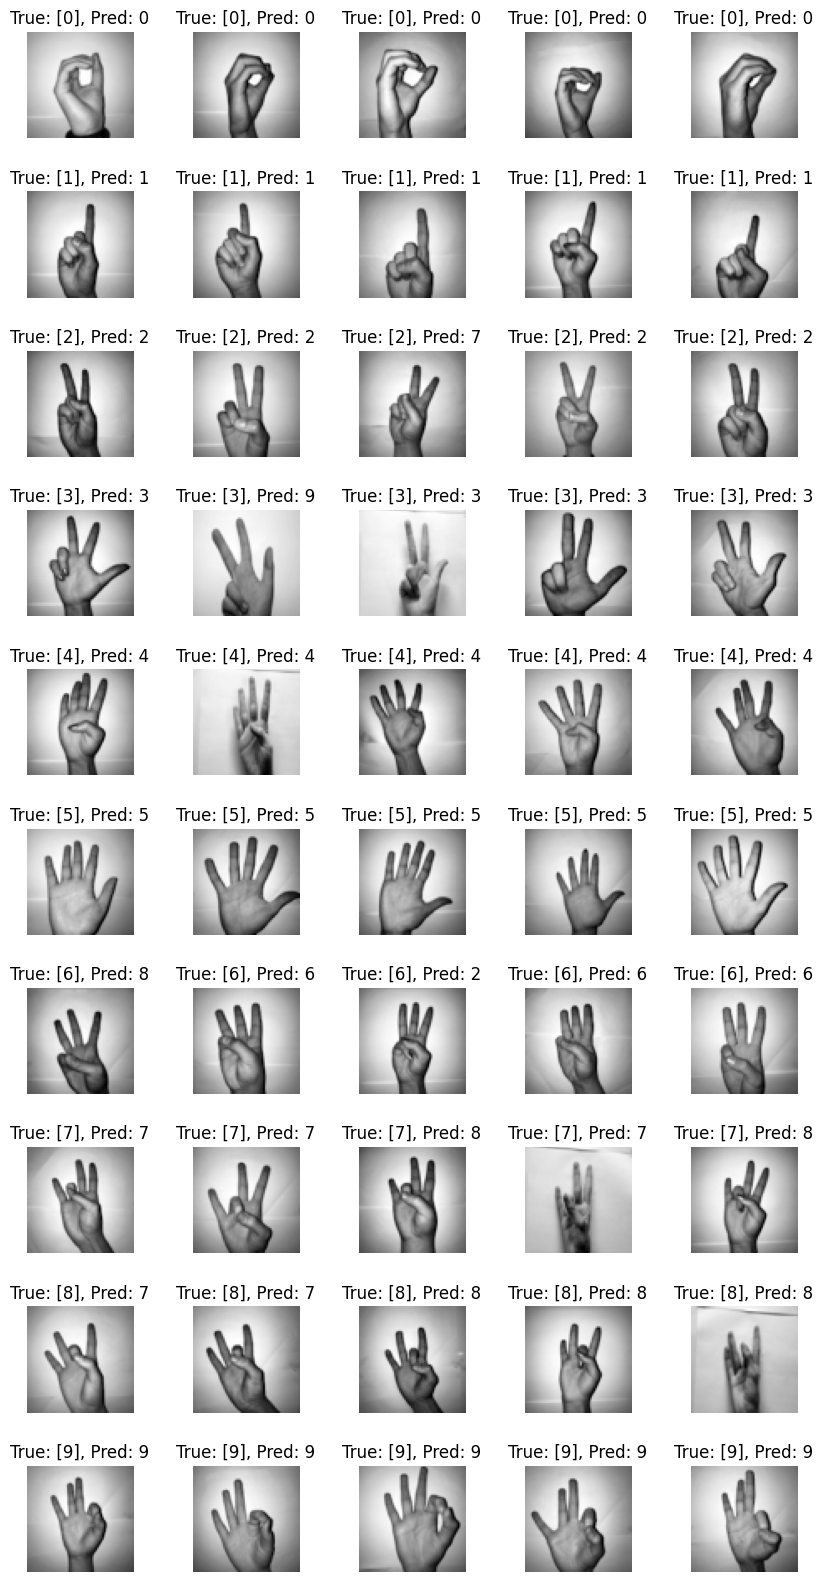

In [23]:
# Suponha que X_train, Y_train, X_test, Y_test, X_val, Y_val, X_original, e Y_original estão definidos corretamente
num_classes = 10  # Por exemplo, para um caso de classificação com 10 classes

# Train and analyze the model with Keras
trained_model, encoder = train_and_analyze_keras_not_tuned(X_train, Y_train, X_test, Y_test, X_val, Y_val, num_classes)

# Choose a random image to test the model
random_images = []

for i in range(10):  # Assumindo 10 classes
    random_images.append(np.where(correted_Y == i)[0][0:5])

random_images = np.array(random_images).flatten()

# Plot the images with predictions
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # Ajustar o tamanho conforme necessário

for idx, image_idx in enumerate(random_images):
    i, j = divmod(idx, 5)
    
    axes[i, j].imshow(correted_X[image_idx], cmap='gray')  # Ajuste aqui se X_original não é a variável correta
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição (certifique-se de que está no formato correto esperado pelo modelo)
    image_prepared = X_flatten[image_idx].reshape(1, -1)  # Ajustar conforme o formato esperado pelo modelo
    
    # Fazer a predição
    pred_prob = trained_model.predict(image_prepared)
    pred_class = np.argmax(pred_prob, axis=-1)
    
    # Utilize o encoder para transformar a previsão de volta para o label original
    pred_label = encoder.inverse_transform(pred_class)[0]
    
    true_label = correted_Y[image_idx]
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Hyperparameter Tuning

In [31]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from kerastuner import RandomSearch
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

# Suponha que X_train, y_train, X_test, y_test, X_val, y_val já estejam definidos

def build_model(hp):
    model = Sequential()
    
    l2 = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling='log')

    model.add(Dense(units=hp.Choice('units', [10, 20, 30, 40, 50]),
                    activation='relu',
                    input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(l2)))  # Aplicando regularização L2 corretamente
    
    model.add(Dense(units=10,  # 'num_classes' deve ser definido fora desta função
                    activation='softmax',
                    kernel_regularizer=regularizers.l2(l2)))

    # Permitindo que o Keras Tuner escolha o learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    momentum = hp.Float('momentum', min_value=0.8, max_value=0.99, step=0.01)
    nesterov = hp.Choice('nesterov', values=[True, False])
    
    #regularization
    

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def hyperparameter_tuning_test(X_train, y_train, X_val, y_val, X_test, y_test):
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_val_encoded = encoder.transform(y_val)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encoding
    num_classes = len(np.unique(y_train_encoded))
    y_train_encoded = np.eye(num_classes)[y_train_encoded]
    y_val_encoded = np.eye(num_classes)[y_val_encoded]
    y_test_encoded = np.eye(num_classes)[y_test_encoded]

    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,  # Um valor intermediário, ajuste conforme sua capacidade computacional
        executions_per_trial=2,
        directory='tuning',
        project_name='keras_tuning'
    )

    tuner.search(X_train, y_train_encoded, epochs=800, validation_data=(X_val, y_val_encoded))

    # Obtendo os melhores hiperparâmetros
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"""
    Otimização de Hiperparâmetros concluída. 
    - Número ótimo de unidades: {best_hps.get('units')}
    - Learning rate ótimo: {best_hps.get('learning_rate')}
    - Momentum ótimo: {best_hps.get('momentum')}
    - Nesterov ótimo: {best_hps.get('nesterov')}
    """)

    # Construindo e treinando o modelo com os melhores hiperparâmetros
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train_encoded, epochs=800, validation_data=(X_val, y_val_encoded))
    
    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Set Loss: {loss},\n Test Set Accuracy: {accuracy}")
    
    # 
    
    # Plotar a evolução da função de custo e da acurácia
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Fazer previsões para análise adicional
    pred_train = np.argmax(model.predict(X_train), axis=-1)
    pred_test = np.argmax(model.predict(X_test), axis=-1)
    pred_val = np.argmax(model.predict(X_val), axis=-1)
    
    # Transformar previsões de volta para rótulos originais
    pred_train = encoder.inverse_transform(pred_train)
    pred_test = encoder.inverse_transform(pred_test)
    pred_val = encoder.inverse_transform(pred_val)
    
    # Metrics and Confusion Matrices
    for (preds, true, name) in [(pred_train, y_train, "Train"), (pred_test, y_test, "Test"), (pred_val, y_val, "Validation")]:
        print(f"\n---- {name} Set Analysis ----")
        accuracy = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')
        print(f"Accuracy: {accuracy}, F1 Score: {f1}")
        print("\nClassification Report:")
        print(classification_report(true, preds))
        
        # Confusion Matrix
        cm = confusion_matrix(true, preds)
        plot_confusion_matrix(cm, target_names=np.unique(y_train).astype(str), title=f'{name} Set Confusion Matrix', normalize=False)
            
    # Certifique-se de retornar ambos, model e encoder
    return model, encoder



## Train and Evaluate the model with the best hyperparameters

Reloading Tuner from tuning/keras_tuning/tuner0.json

    Otimização de Hiperparâmetros concluída. 
    - Número ótimo de unidades: 50
    - Learning rate ótimo: 0.0002631926470261117
    - Momentum ótimo: 0.8400000000000001
    - Nesterov ótimo: 1
    
Epoch 1/800


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1154 - loss: 2.2979 - val_accuracy: 0.2097 - val_loss: 2.2628
Epoch 2/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1805 - loss: 2.2667 - val_accuracy: 0.1839 - val_loss: 2.2732
Epoch 3/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1719 - loss: 2.2579 - val_accuracy: 0.1806 - val_loss: 2.2356
Epoch 4/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1751 - loss: 2.2261 - val_accuracy: 0.2419 - val_loss: 2.2014
Epoch 5/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2436 - loss: 2.2109 - val_accuracy: 0.3000 - val_loss: 2.1898
Epoch 6/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2599 - loss: 2.1874 - val_accuracy: 0.2839 - val_loss: 2.1737
Epoch 7/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2876 - loss: 2.1607 - val_accuracy: 0.3161 - val_loss: 2.1507
Epoch 8/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3499 - loss: 2.1288 - val_accuracy: 0.3645 - val_loss: 2.1

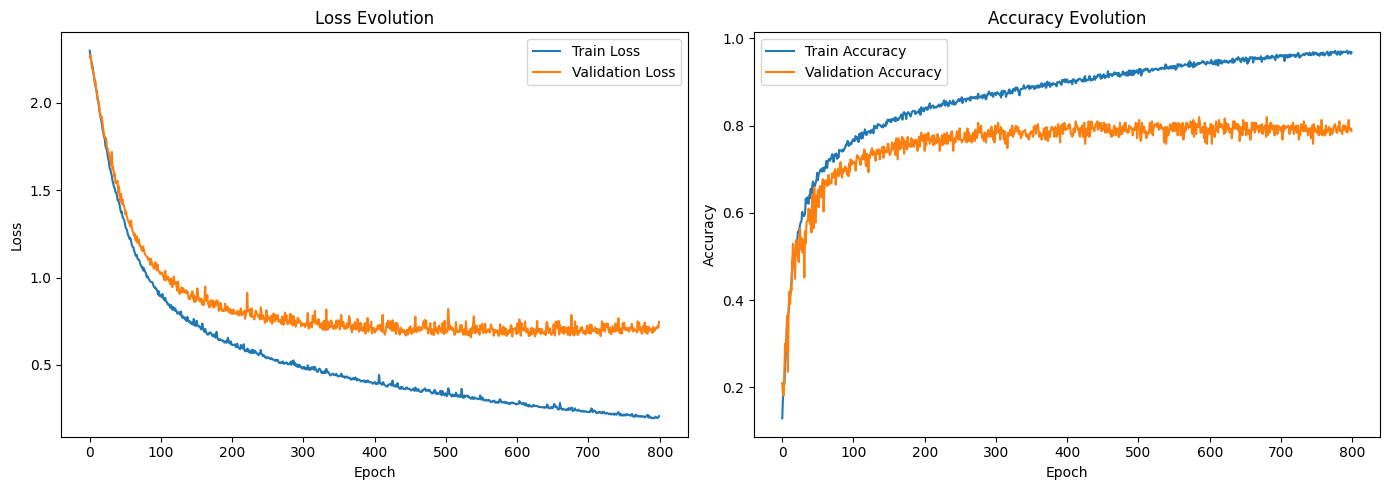

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step

---- Train Set Analysis ----
Accuracy: 0.9625779625779626, F1 Score: 0.9628770607601633

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.94      0.99      0.97       136
           2       1.00      0.92      0.96       130
           3       0.99      0.99      0.99       143
           4       0.96      0.92      0.94       155
           5       1.00      0.99      1.00       152
           6       0.99      0.90      0.94       142
           7       0.85      0.99      0.91       144
           8       0.95      0.97      0.96       146
           9       0.99      0.98      0.98       145

    accuracy                           0.96      1443
   macro avg       0.97      0.96      0.96      1443
weighted avg       0.97      0.96      0.96      1443



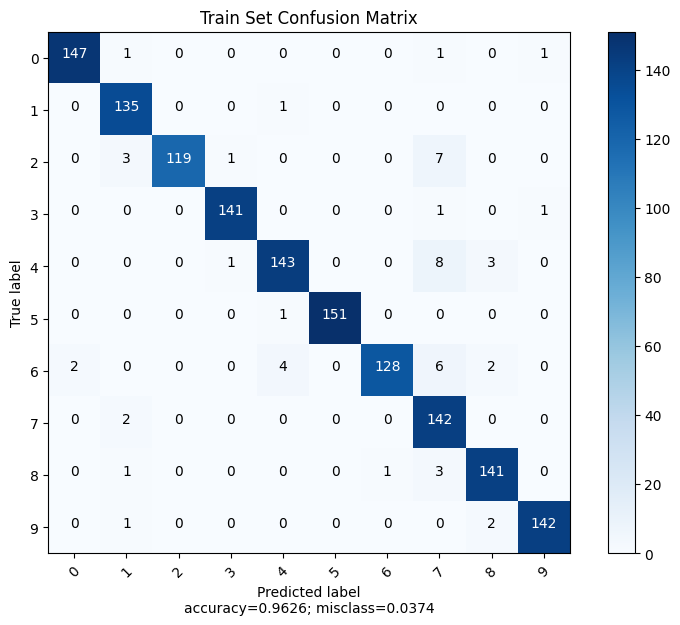


---- Test Set Analysis ----
Accuracy: 0.7799352750809061, F1 Score: 0.7804213530444685

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        27
           1       0.95      0.92      0.93        38
           2       0.81      0.63      0.71        35
           3       0.81      1.00      0.90        30
           4       0.72      0.72      0.72        32
           5       0.84      0.88      0.86        24
           6       0.82      0.68      0.74        34
           7       0.53      0.72      0.61        32
           8       0.72      0.75      0.74        28
           9       0.91      0.69      0.78        29

    accuracy                           0.78       309
   macro avg       0.79      0.78      0.78       309
weighted avg       0.79      0.78      0.78       309



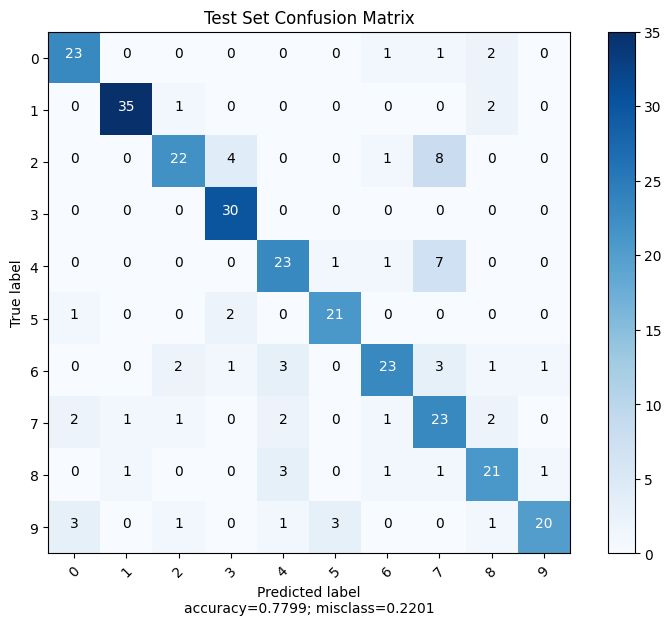


---- Validation Set Analysis ----
Accuracy: 0.7870967741935484, F1 Score: 0.7847701320561087

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.83      0.78      0.81        32
           2       0.75      0.51      0.61        41
           3       0.88      0.88      0.88        33
           4       0.67      0.70      0.68        20
           5       0.91      0.94      0.92        31
           6       0.88      0.68      0.76        31
           7       0.58      0.93      0.72        30
           8       0.83      0.74      0.78        34
           9       0.74      0.87      0.80        30

    accuracy                           0.79       310
   macro avg       0.80      0.79      0.79       310
weighted avg       0.80      0.79      0.78       310



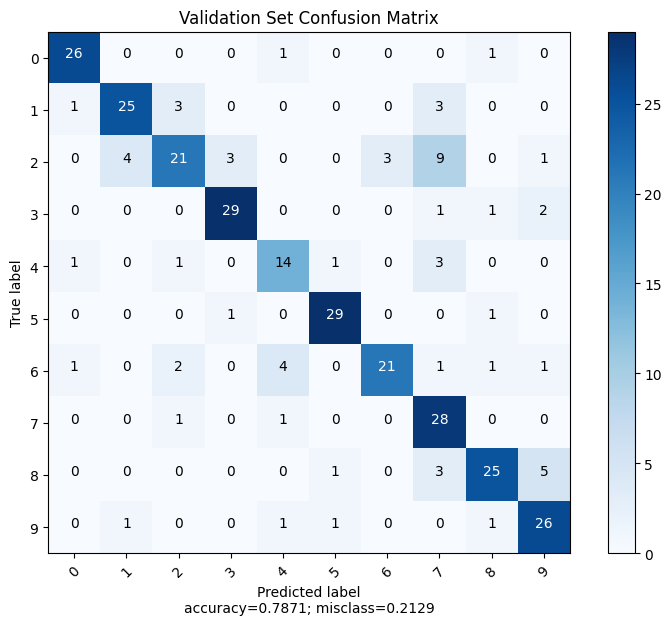

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

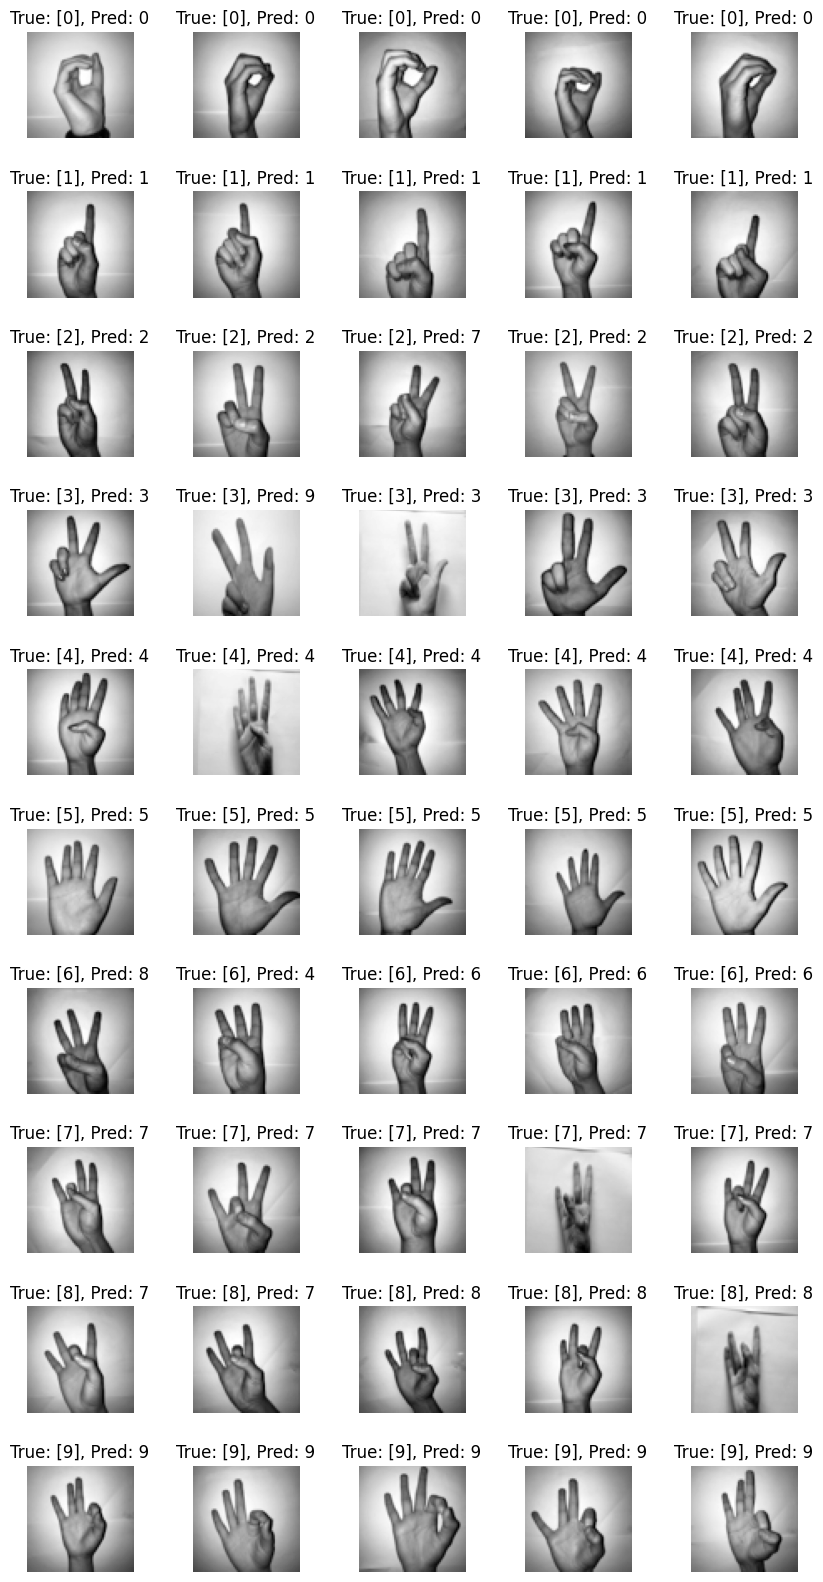

In [32]:
# Suponha que X_train, Y_train, X_test, Y_test, X_val, Y_val, X_original, e Y_original estão definidos corretamente
num_classes = 10  # Por exemplo, para um caso de classificação com 10 classes

# Train and analyze the model with Keras
trained_model, encoder = hyperparameter_tuning_test(X_train, Y_train, X_val, Y_val, X_test, Y_test)

# Choose a random image to test the model
random_images = []

for i in range(10):  # Assumindo 10 classes
    random_images.append(np.where(correted_Y == i)[0][0:5])

random_images = np.array(random_images).flatten()

# Plot the images with predictions
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # Ajustar o tamanho conforme necessário

for idx, image_idx in enumerate(random_images):
    i, j = divmod(idx, 5)
    
    axes[i, j].imshow(correted_X[image_idx], cmap='gray')  # Ajuste aqui se X_original não é a variável correta
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição (certifique-se de que está no formato correto esperado pelo modelo)
    image_prepared = X_flatten[image_idx].reshape(1, -1)  # Ajustar conforme o formato esperado pelo modelo
    
    # Fazer a predição
    pred_prob = trained_model.predict(image_prepared)
    pred_class = np.argmax(pred_prob, axis=-1)
    
    # Utilize o encoder para transformar a previsão de volta para o label original
    pred_label = encoder.inverse_transform(pred_class)[0]
    
    true_label = correted_Y[image_idx]
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

## Print of the wrong predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Number of errors: 68
Percentage of errors: 22.01%


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


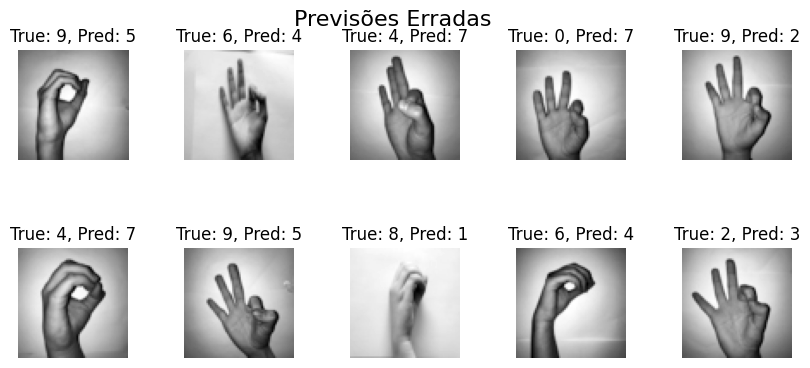

In [45]:
# Primeiro, obtemos as previsões para todo o conjunto de teste
preds_test = trained_model.predict(X_test)
preds_test_classes = np.argmax(preds_test, axis=-1)
true_test_classes = Y_test  # Supondo que Y_test contém os labels verdadeiros do conjunto de teste

# Converter os labels verdadeiros e previstos de volta para as etiquetas originais, se necessário
if encoder is not None:
    true_test_labels = encoder.inverse_transform(true_test_classes)
    preds_test_labels = encoder.inverse_transform(preds_test_classes)
else:
    true_test_labels = true_test_classes
    preds_test_labels = preds_test_classes

# Encontrar os índices dos erros
error_indices = np.where(preds_test_labels != true_test_labels)[0]

#print the number of errors
print(f"Number of errors: {len(error_indices)}")

#print the percentage of errors
print(f"Percentage of errors: {len(error_indices)/len(true_test_labels)*100:.2f}%")

# Escolher um subconjunto desses erros para plotar
error_sample_indices = np.random.choice(error_indices, size=min(10, len(error_indices)), replace=False)

# Plotar as imagens com erros
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Ajuste o layout conforme necessário
fig.suptitle('Previsões Erradas', fontsize=16)
for idx, error_idx in enumerate(error_sample_indices):
    i, j = divmod(idx, 5)
    axes[i, j].imshow(X_original[error_idx], cmap='gray')
    axes[i, j].axis('off')
    axes[i, j].set_title(f"True: {true_test_labels[error_idx]}, Pred: {preds_test_labels[error_idx]}")

plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Number of errors: 68
Percentage of errors: 22.01%


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


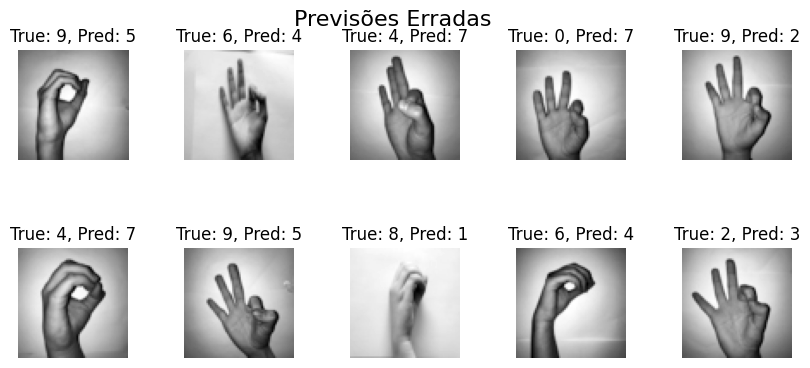

In [ ]:
# Primeiro, obtemos as previsões para todo o conjunto de teste
preds_test = trained_model.predict(X_test)
preds_test_classes = np.argmax(preds_test, axis=-1)
true_test_classes = Y_test  # Supondo que Y_test contém os labels verdadeiros do conjunto de teste

# Converter os labels verdadeiros e previstos de volta para as etiquetas originais, se necessário
if encoder is not None:
    true_test_labels = encoder.inverse_transform(true_test_classes)
    preds_test_labels = encoder.inverse_transform(preds_test_classes)
else:
    true_test_labels = true_test_classes
    preds_test_labels = preds_test_classes

# Encontrar os índices dos erros
error_indices = np.where(preds_test_labels != true_test_labels)[0]

#print the number of errors
print(f"Number of errors: {len(error_indices)}")

#print the percentage of errors
print(f"Percentage of errors: {len(error_indices)/len(true_test_labels)*100:.2f}%")

# Escolher um subconjunto desses erros para plotar
error_sample_indices = np.random.choice(error_indices, size=min(10, len(error_indices)), replace=False)

# Plotar as imagens com erros
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Ajuste o layout conforme necessário
fig.suptitle('Previsões Erradas', fontsize=16)
for idx, error_idx in enumerate(error_sample_indices):
    i, j = divmod(idx, 5)
    axes[i, j].imshow(X_original[error_idx], cmap='gray')
    axes[i, j].axis('off')
    axes[i, j].set_title(f"True: {true_test_labels[error_idx]}, Pred: {preds_test_labels[error_idx]}")

plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()
